# GO-BGC Argopy Workshop

In [1]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # Functions to easily make maps and plots

# Make a fresh start
import argopy
argopy.set_options(cachedir='cache_bgc')
#argopy.reset_options()
argopy.clear_cache()

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean.cm as cmo
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns
xr.set_options(display_expand_attrs = False)

# Load Storm Track

In [109]:
traj = pd.read_csv('sam_2021_ibtracs_data.csv')
traj_rows = traj.set_index(["ISO_TIME"])  # since this is a gridded data, it is useful to transorm from a table into an array 
traj_ds = xr.Dataset.from_dataframe(traj_rows)
traj_ds

<xarray.Dataset>
Dimensions:           (ISO_TIME: 117)
Coordinates:
  * ISO_TIME          (ISO_TIME) object '2021-09-22 18:00:00' ... '2021-10-07...
Data variables: (12/163)
    Unnamed: 0        (ISO_TIME) int64 0 1 2 3 4 5 6 ... 111 112 113 114 115 116
    SID               (ISO_TIME) object '2021266N10327' ... '2021266N10327'
    SEASON            (ISO_TIME) int64 2021 2021 2021 2021 ... 2021 2021 2021
    NUMBER            (ISO_TIME) int64 85 85 85 85 85 85 ... 85 85 85 85 85 85
    BASIN             (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    SUBBASIN          (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    ...                ...
    USA_SEARAD_NE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_NW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    STORM_SPEED       (ISO_TIME) int64 12 13 14 16 16 16 ... 26 28 30 32 34 34
    STORM_DIR         (ISO_TIME) int64 280 279 278 277 279 ... 49 45 37 30 28

# Load Float Data

In [110]:
my_WMO = 5906436 #my hurricane ID
my_float= DataFetcher(ds='bgc', src='erddap',mode='expert', params='all',progress=True).float(my_WMO).load()
#my_float = xr.open_dataset('5906436_Sprof.nc')

In [111]:
float_ds = my_float.data
float_ds = float_ds.argo.teos10(['CT','SA','SIG0'])

In [112]:
float_ds = float_ds.argo.point2profile()
float_ds

<xarray.Dataset>
Dimensions:                          (N_PROF: 62, N_LEVELS: 557)
Coordinates:
  * N_PROF                           (N_PROF) int64 0 1 2 3 4 ... 57 58 59 60 61
  * N_LEVELS                         (N_LEVELS) int64 0 1 2 3 ... 554 555 556
    LATITUDE                         (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                        (N_PROF) float64 -65.73 -65.01 ... -51.47
    TIME                             (N_PROF) datetime64[ns] 2021-05-04T10:58...
Data variables: (12/57)
    BBP700                           (N_PROF, N_LEVELS) float32 nan nan ... nan
    BBP700_ADJUSTED                  (N_PROF, N_LEVELS) float32 1e+05 ... nan
    BBP700_ADJUSTED_ERROR            (N_PROF) float32 1e+05 1e+05 ... 1e+05
    BBP700_ADJUSTED_QC               (N_PROF, N_LEVELS) int64 0 0 0 ... 1 99999
    BBP700_DATA_MODE                 (N_PROF) <U1 'A' 'A' 'A' ... 'A' 'A' 'A'
    BBP700_QC                        (N_PROF, N_LEVELS) int64 0 0 0 ... 2 99999
    ...                               ...
    TEMP_ADJUSTED                    (N_PROF, N_LEVELS) float32 26.36 ... nan
    TEMP_ADJUSTED_ERROR              (N_PROF, N_LEVELS) float32 0.002 ... nan
    TEMP_ADJUSTED_QC                 (N_PROF, N_LEVELS) int64 1 1 1 ... 1 99999
    TEMP_DATA_MODE                   (N_PROF) <U1 'D' 'D' 'D' ... 'D' 'D' 'D'
    TEMP_QC                          (N_PROF, N_LEVELS) int64 1 1 1 ... 1 99999
    TIME_QC                          (N_PROF) int64 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes: (8)

In [113]:
float_ds.to_netcdf('float:{}.nc'.format(my_WMO))

In [114]:
float_ds['PH_IN_SITU_TOTAL_ADJUSTED'] = float_ds['PH_IN_SITU_TOTAL_ADJUSTED'].where(float_ds['PH_IN_SITU_TOTAL_ADJUSTED'] != 99999.)
float_ds['NITRATE_ADJUSTED'] = float_ds['NITRATE_ADJUSTED'].where(float_ds['NITRATE_ADJUSTED'] != 99999.)
float_ds['CHLA_ADJUSTED'] = float_ds['CHLA_ADJUSTED'].where(float_ds['CHLA_ADJUSTED'] != 99999.)

In [282]:
float_ds['CHLA_ROLLING']   = float_ds.CHLA_ADJUSTED.rolling(N_LEVELS=3,min_periods=1,center=True).mean()
float_ds['BBP700_ROLLING'] = float_ds.BBP700.rolling(N_LEVELS=5,min_periods=1,center=True).mean()

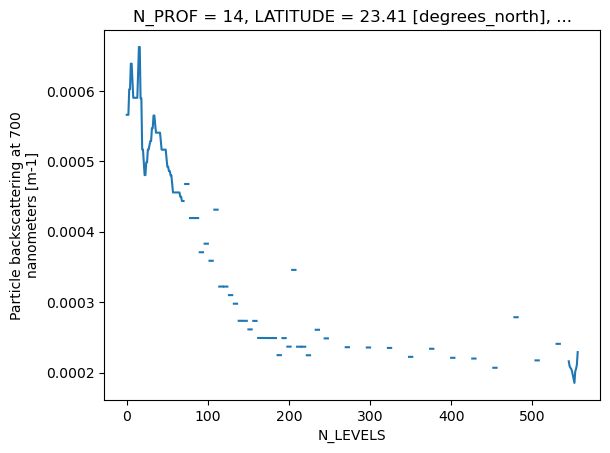

In [283]:
float_ds.isel(N_PROF=14).BBP700_ROLLING.plot()

In [284]:
depth_min = 0
depth_max = 1000
step = 2
grid = np.arange(depth_min,depth_max,step)

In [285]:
float_interp = float_ds.argo.interp_std_levels(grid)
float_interp

<xarray.Dataset>
Dimensions:                     (N_PROF: 62, PRES_INTERPOLATED: 500)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
    TIME                        (N_PROF) datetime64[ns] 2021-05-04T10:58:27.0...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) int64 0 2 4 ... 994 996 998
Data variables: (12/33)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    BBP700_ROLLING              (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 0.0365 .....
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 0.0073 .....
    ...                          ...
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    SA                          (N_PROF, PRES_INTERPOLATED) float64 36.92 ......
    SIG0                        (N_PROF, PRES_INTERPOLATED) float64 24.24 ......
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

# Define Date of Intersection

In [286]:
print('first storm traj: {}, last storm traj: {}'.format(traj_ds.ISO_TIME.min().data,traj_ds.ISO_TIME.max().data))

first storm traj: 2021-09-22T18:00:00.000000000, last storm traj: 2021-10-07T06:00:00.000000000


In [287]:
print('first float prof: {}, last float prof: {}'.format(float_interp.TIME.min().data,float_interp.TIME.max().data))

first float prof: 2021-05-04T10:58:27.000999936, last float prof: 2023-05-09T20:35:34.002000128


In [288]:
float_interp.isel(N_PROF=15).TIME

<xarray.DataArray 'TIME' ()>
array('2021-10-02T11:32:06.000999936', dtype='datetime64[ns]')
Coordinates:
    N_PROF     int64 15
    LATITUDE   float64 23.16
    LONGITUDE  float64 -61.45
    TIME       datetime64[ns] 2021-10-02T11:32:06.000999936
Attributes: (10)

In [289]:
traj_ds['ISO_TIME'] = pd.DatetimeIndex(traj_ds['ISO_TIME'].values)
traj_ds

<xarray.Dataset>
Dimensions:           (ISO_TIME: 117)
Coordinates:
  * ISO_TIME          (ISO_TIME) datetime64[ns] 2021-09-22T18:00:00 ... 2021-...
Data variables: (12/163)
    Unnamed: 0        (ISO_TIME) int64 0 1 2 3 4 5 6 ... 111 112 113 114 115 116
    SID               (ISO_TIME) object '2021266N10327' ... '2021266N10327'
    SEASON            (ISO_TIME) int64 2021 2021 2021 2021 ... 2021 2021 2021
    NUMBER            (ISO_TIME) int64 85 85 85 85 85 85 ... 85 85 85 85 85 85
    BASIN             (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    SUBBASIN          (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    ...                ...
    USA_SEARAD_NE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_NW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    STORM_SPEED       (ISO_TIME) int64 12 13 14 16 16 16 ... 26 28 30 32 34 34
    STORM_DIR         (ISO_TIME) int64 280 279 278 277 279 ... 49 45 37 30 28

In [290]:
float_interp.N_PROF

<xarray.DataArray 'N_PROF' (N_PROF: 62)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61])
Coordinates:
  * N_PROF     (N_PROF) int64 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61
    LATITUDE   (N_PROF) float64 23.87 24.05 24.27 24.59 ... 24.21 24.29 25.1
    LONGITUDE  (N_PROF) float64 -65.73 -65.01 -64.58 ... -52.88 -52.67 -51.47
    TIME       (N_PROF) datetime64[ns] 2021-05-04T10:58:27.000999936 ... 2023...
Attributes: (1)

In [291]:
N_PROF_during = int(float_interp.N_PROF.where(float_interp.TIME>=traj_ds.ISO_TIME.min()).where(float_interp.TIME<=traj_ds.ISO_TIME.max()).dropna('N_PROF').data)
N_PROF_during

/tmp/ipykernel_65095/2055117231.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  N_PROF_during = int(float_interp.N_PROF.where(float_interp.TIME>=traj_ds.ISO_TIME.min()).where(float_interp.TIME<=traj_ds.ISO_TIME.max()).dropna('N_PROF').data)


15

In [292]:
TIME_POSITION = []
for n in range(0,len(float_interp.N_PROF)):
    if n < N_PROF_during:
        TIME_POSITION.append('B')
        
    elif n== N_PROF_during:
        TIME_POSITION.append('D')
        
    elif n > N_PROF_during:
        TIME_POSITION.append('A')

In [293]:
len(TIME_POSITION)

62

In [294]:
float_interp['TIME_POSITION'] = TIME_POSITION
float_interp['TIME'] = float_interp.TIME.data
float_interp

<xarray.Dataset>
Dimensions:                     (N_PROF: 62, PRES_INTERPOLATED: 500, TIME: 62,
                                 TIME_POSITION: 62)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
  * TIME                        (TIME) datetime64[ns] 2021-05-04T10:58:27.000...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) int64 0 2 4 ... 994 996 998
  * TIME_POSITION               (TIME_POSITION) <U1 'B' 'B' 'B' ... 'A' 'A' 'A'
Data variables: (12/33)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    BBP700_ROLLING              (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 0.0365 .....
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 0.0073 .....
    ...                          ...
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    SA                          (N_PROF, PRES_INTERPOLATED) float64 36.92 ......
    SIG0                        (N_PROF, PRES_INTERPOLATED) float64 24.24 ......
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

# Plot Trajectories

In [295]:
traj_ds

<xarray.Dataset>
Dimensions:           (ISO_TIME: 117)
Coordinates:
  * ISO_TIME          (ISO_TIME) datetime64[ns] 2021-09-22T18:00:00 ... 2021-...
Data variables: (12/163)
    Unnamed: 0        (ISO_TIME) int64 0 1 2 3 4 5 6 ... 111 112 113 114 115 116
    SID               (ISO_TIME) object '2021266N10327' ... '2021266N10327'
    SEASON            (ISO_TIME) int64 2021 2021 2021 2021 ... 2021 2021 2021
    NUMBER            (ISO_TIME) int64 85 85 85 85 85 85 ... 85 85 85 85 85 85
    BASIN             (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    SUBBASIN          (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    ...                ...
    USA_SEARAD_NE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_NW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    STORM_SPEED       (ISO_TIME) int64 12 13 14 16 16 16 ... 26 28 30 32 34 34
    STORM_DIR         (ISO_TIME) int64 280 279 278 277 279 ... 49 45 37 30 28

In [296]:
float_interp

<xarray.Dataset>
Dimensions:                     (N_PROF: 62, PRES_INTERPOLATED: 500, TIME: 62,
                                 TIME_POSITION: 62)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
  * TIME                        (TIME) datetime64[ns] 2021-05-04T10:58:27.000...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) int64 0 2 4 ... 994 996 998
  * TIME_POSITION               (TIME_POSITION) <U1 'B' 'B' 'B' ... 'A' 'A' 'A'
Data variables: (12/33)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    BBP700_ROLLING              (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 0.0365 .....
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 0.0073 .....
    ...                          ...
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    SA                          (N_PROF, PRES_INTERPOLATED) float64 36.92 ......
    SIG0                        (N_PROF, PRES_INTERPOLATED) float64 24.24 ......
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

Text(0.5, 1.0, 'Float & Sam Trajectories')

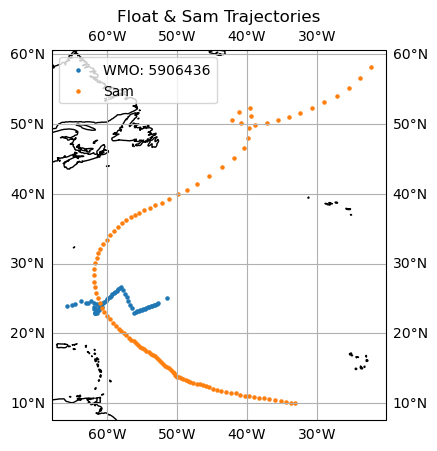

In [297]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(float_interp.LONGITUDE,float_interp.LATITUDE,transform=ccrs.PlateCarree(),s=5,label='WMO: {}'.format(float_interp.PLATFORM_NUMBER[0].data))
plt.scatter(traj_ds.LON,traj_ds.LAT,transform=ccrs.PlateCarree(),s=5,label='Sam')
#ax.set_extent([-70,-50,20,30])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.legend()
plt.title('Float & Sam Trajectories')

In [298]:
float_interp.TIME[15]

<xarray.DataArray 'TIME' ()>
array('2021-10-02T11:32:06.000999936', dtype='datetime64[ns]')
Coordinates:
    TIME     datetime64[ns] 2021-10-02T11:32:06.000999936

In [299]:
traj_ds.sel(ISO_TIME='2021-10-02T12:00:00').LAT

<xarray.DataArray 'LAT' ()>
array(33.4)
Coordinates:
    ISO_TIME  datetime64[ns] 2021-10-02T12:00:00

In [441]:
traj_ds.sel(ISO_TIME='2021-10-02T11:32:06.000999936',method='nearest')

<xarray.Dataset>
Dimensions:           ()
Coordinates:
    ISO_TIME          datetime64[ns] 2021-10-02T12:00:00
Data variables: (12/163)
    Unnamed: 0        int64 78
    SID               object '2021266N10327'
    SEASON            int64 2021
    NUMBER            int64 85
    BASIN             float64 nan
    SUBBASIN          float64 nan
    ...                ...
    USA_SEARAD_NE     object '270'
    USA_SEARAD_SE     object '330'
    USA_SEARAD_SW     object '300'
    USA_SEARAD_NW     object '270'
    STORM_SPEED       int64 15
    STORM_DIR         int64 32

Text(0.5, 1.0, 'Float & Sam Trajectories')

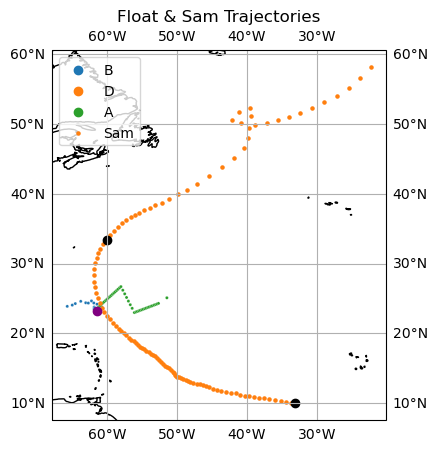

In [442]:
ax = plt.axes(projection=ccrs.PlateCarree())
sns.scatterplot(x=float_interp.LONGITUDE,y=float_interp.LATITUDE,hue=float_interp.TIME_POSITION,transform=ccrs.PlateCarree(),s=5)
plt.scatter(traj_ds.LON,traj_ds.LAT,transform=ccrs.PlateCarree(),s=5,label='Sam')
plt.scatter(float_interp.isel(N_PROF=15).LONGITUDE,float_interp.isel(N_PROF=15).LATITUDE,color='purple')
plt.scatter(traj_ds.sel(ISO_TIME='2021-09-22T18:00:00').LON,traj_ds.sel(ISO_TIME='2021-09-22T18:00:00').LAT,color='black')
plt.scatter(traj_ds.sel(ISO_TIME='2021-10-02T12:00:00').LON,traj_ds.sel(ISO_TIME='2021-10-02T12:00:00').LAT,color='black')
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.legend()
plt.title('Float & Sam Trajectories')

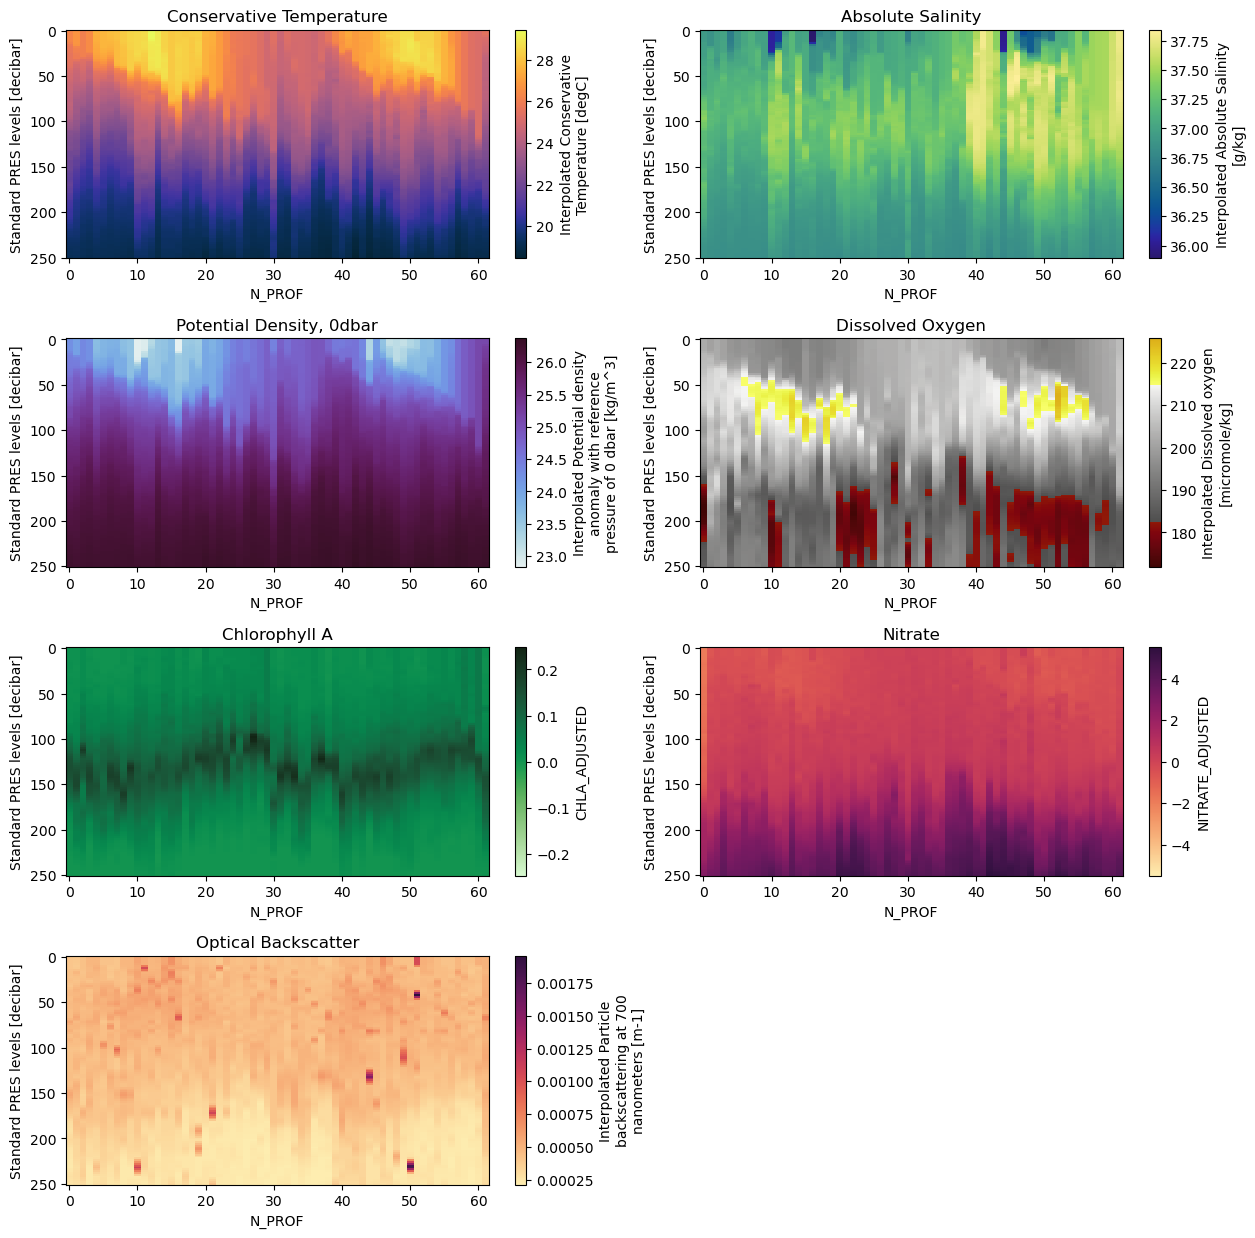

In [303]:
plt.figure(figsize=(15,15))

plt.subplot(421)
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).CT.plot(y='PRES_INTERPOLATED',cmap=cmo.thermal)
plt.gca().invert_yaxis()
plt.title('Conservative Temperature')

plt.subplot(422)
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).SA.plot(y='PRES_INTERPOLATED',cmap=cmo.haline)
plt.gca().invert_yaxis()
plt.title('Absolute Salinity')

plt.subplot(423)
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).SIG0.plot(y='PRES_INTERPOLATED',cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.title('Potential Density, 0dbar')

plt.subplot(424)
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).DOXY_ADJUSTED.plot(y='PRES_INTERPOLATED',cmap=cmo.oxy)
plt.gca().invert_yaxis()
plt.title('Dissolved Oxygen')

plt.subplot(425)
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).CHLA_ADJUSTED.plot(y='PRES_INTERPOLATED',cmap=cmo.algae)
plt.gca().invert_yaxis()
plt.title('Chlorophyll A')

plt.subplot(426)
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).NITRATE_ADJUSTED.plot(y='PRES_INTERPOLATED',cmap=cmo.matter)
plt.gca().invert_yaxis()
plt.title('Nitrate')

plt.subplot(427)
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).BBP700.plot(y='PRES_INTERPOLATED',cmap=cmo.matter)
plt.gca().invert_yaxis()
plt.title('Optical Backscatter')

plt.subplots_adjust(hspace=0.35)

# Plot MLD Depth

In [304]:
def get_MLD(ds,threshold=0.03,variable='SIG0',dim1='N_PROF',dim2='PRES_INTERPOLATED'):
    '''Takes an xarray and returns a new coordinate "MLD" or mixed layer depth for each profile, defined using the density threshold from the surface.
    ds: xarray with profile and pressure dimensions
    threshold: density value that defines the boundary of the mixed layer, default=0.03
    variable: density coordinate, default='SIG0'
    dim1: profile dimension, default='N_PROF'
    dim2: pressure dimension, default='PRES_INTERPOLATED'
    '''
    
    MLD_li = []
    
    for n in range(0, len(ds[dim1])):
        SIG0_surface = ds.isel({dim1:n})[variable].isel({dim2:0})
        SIG0_diff    = SIG0_surface + threshold
        MLD_ds       = SIG0_surface.where(ds.isel({dim1:n})[variable] < SIG0_diff)
        MLD          = MLD_ds.dropna(dim2).isel({dim2:-1})[dim2].values
        MLD_li.append(MLD)
        
    return ds.assign_coords(MLD=(dim1,MLD_li))

In [369]:
float_interp = get_MLD(float_interp,0.125)

Text(0.5, 1.0, 'Densite with MLD Contour')

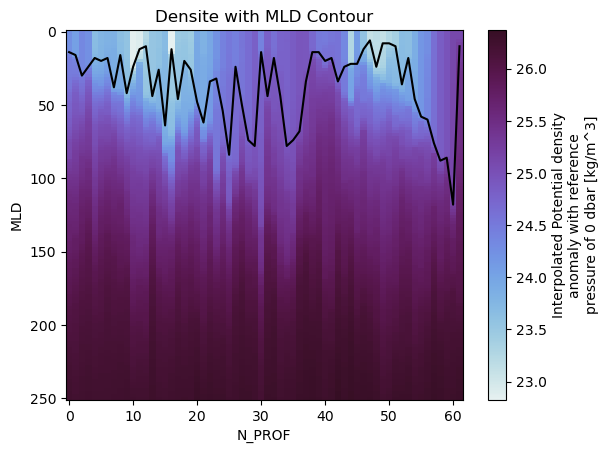

In [370]:
float_interp.sel(PRES_INTERPOLATED=slice(0,250)).SIG0.plot(y='PRES_INTERPOLATED',cmap=cmo.dense)
plt.gca().invert_yaxis()
float_interp.MLD.plot(color='k')
plt.title('Densite with MLD Contour')

# Bin Data

In [307]:
bins = np.arange(0,1000,10)
float_binned = float_interp.groupby_bins('PRES_INTERPOLATED',bins).sum()
float_binned

<xarray.Dataset>
Dimensions:                     (PRES_INTERPOLATED_bins: 99, N_PROF: 62,
                                 TIME: 62, TIME_POSITION: 62)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
  * TIME                        (TIME) datetime64[ns] 2021-05-04T10:58:27.000...
  * TIME_POSITION               (TIME_POSITION) <U1 'B' 'B' 'B' ... 'A' 'A' 'A'
    MLD                         (N_PROF) int64 12 16 28 22 12 ... 70 86 84 112 4
  * PRES_INTERPOLATED_bins      (PRES_INTERPOLATED_bins) object (0, 10] ... (...
Data variables: (12/33)
    BBP700                      (PRES_INTERPOLATED_bins, N_PROF) float32 0.00...
    BBP700_ADJUSTED             (PRES_INTERPOLATED_bins, N_PROF) float32 3.94...
    BBP700_DATA_MODE            (PRES_INTERPOLATED_bins, N_PROF) <U1 'A' ... 'A'
    BBP700_ROLLING              (PRES_INTERPOLATED_bins, N_PROF) float32 0.00...
    CHLA                        (PRES_INTERPOLATED_bins, N_PROF) float32 0.18...
    CHLA_ADJUSTED               (PRES_INTERPOLATED_bins, N_PROF) float32 0.03...
    ...                          ...
    PSAL_DATA_MODE              (PRES_INTERPOLATED_bins, N_PROF) <U1 'D' ... 'D'
    SA                          (PRES_INTERPOLATED_bins, N_PROF) float64 184....
    SIG0                        (PRES_INTERPOLATED_bins, N_PROF) float64 121....
    TEMP                        (PRES_INTERPOLATED_bins, N_PROF) float32 131....
    TEMP_ADJUSTED               (PRES_INTERPOLATED_bins, N_PROF) float32 131....
    TEMP_DATA_MODE              (PRES_INTERPOLATED_bins, N_PROF) <U1 'D' ... 'D'
Attributes: (8)

In [308]:
float_sum = float_binned.sel(PRES_INTERPOLATED_bins=slice(0,250)).sum('PRES_INTERPOLATED_bins')
float_sum

<xarray.Dataset>
Dimensions:                    (N_PROF: 62, TIME: 62, TIME_POSITION: 62)
Coordinates:
  * N_PROF                     (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                   (N_PROF) float64 23.87 24.05 24.27 ... 24.29 25.1
    LONGITUDE                  (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
  * TIME                       (TIME) datetime64[ns] 2021-05-04T10:58:27.0009...
  * TIME_POSITION              (TIME_POSITION) <U1 'B' 'B' 'B' ... 'A' 'A' 'A'
    MLD                        (N_PROF) int64 12 16 28 22 12 ... 70 86 84 112 4
Data variables: (12/24)
    BBP700                     (N_PROF) float32 0.0499 0.05297 ... 0.05908
    BBP700_ADJUSTED            (N_PROF) float32 1.228e+07 ... 1.246e+07
    BBP700_ROLLING             (N_PROF) float32 0.04983 0.05293 ... 0.05902
    CHLA                       (N_PROF) float32 13.66 15.29 17.27 ... 14.4 16.02
    CHLA_ADJUSTED              (N_PROF) float32 5.459 6.274 7.35 ... 7.417 6.642
    CHLA_ROLLING               (N_PROF) float32 5.466 6.269 ... 7.392 6.636
    ...                         ...
    PSAL                       (N_PROF) float32 4.616e+03 ... 4.659e+03
    PSAL_ADJUSTED              (N_PROF) float32 4.616e+03 ... 4.659e+03
    SA                         (N_PROF) float64 4.638e+03 ... 4.681e+03
    SIG0                       (N_PROF) float64 3.181e+03 ... 3.224e+03
    TEMP                       (N_PROF) float32 2.849e+03 ... 2.815e+03
    TEMP_ADJUSTED              (N_PROF) float32 2.849e+03 ... 2.815e+03

In [309]:
float_interp.isel(PRES_INTERPOLATED=0)

<xarray.Dataset>
Dimensions:                     (N_PROF: 62, TIME: 62, TIME_POSITION: 62)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
  * TIME                        (TIME) datetime64[ns] 2021-05-04T10:58:27.000...
    PRES_INTERPOLATED           int64 0
  * TIME_POSITION               (TIME_POSITION) <U1 'B' 'B' 'B' ... 'A' 'A' 'A'
    MLD                         (N_PROF) int64 12 16 28 22 12 ... 70 86 84 112 4
Data variables: (12/33)
    BBP700                      (N_PROF) float32 0.0004087 ... 0.0005037
    BBP700_ADJUSTED             (N_PROF) float32 1e+05 1e+05 ... 1e+05 1e+05
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    BBP700_ROLLING              (N_PROF) float32 0.0004087 ... 0.0005037
    CHLA                        (N_PROF) float32 0.0365 0.0365 ... 0.0365 0.0438
    CHLA_ADJUSTED               (N_PROF) float32 0.0073 0.0073 ... 0.01095
    ...                          ...
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    SA                          (N_PROF) float64 36.92 36.86 ... 37.64 37.77
    SIG0                        (N_PROF) float64 24.24 24.05 ... 25.11 25.12
    TEMP                        (N_PROF) float32 26.36 26.82 ... 25.29 25.6
    TEMP_ADJUSTED               (N_PROF) float32 26.36 26.82 ... 25.29 25.6
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

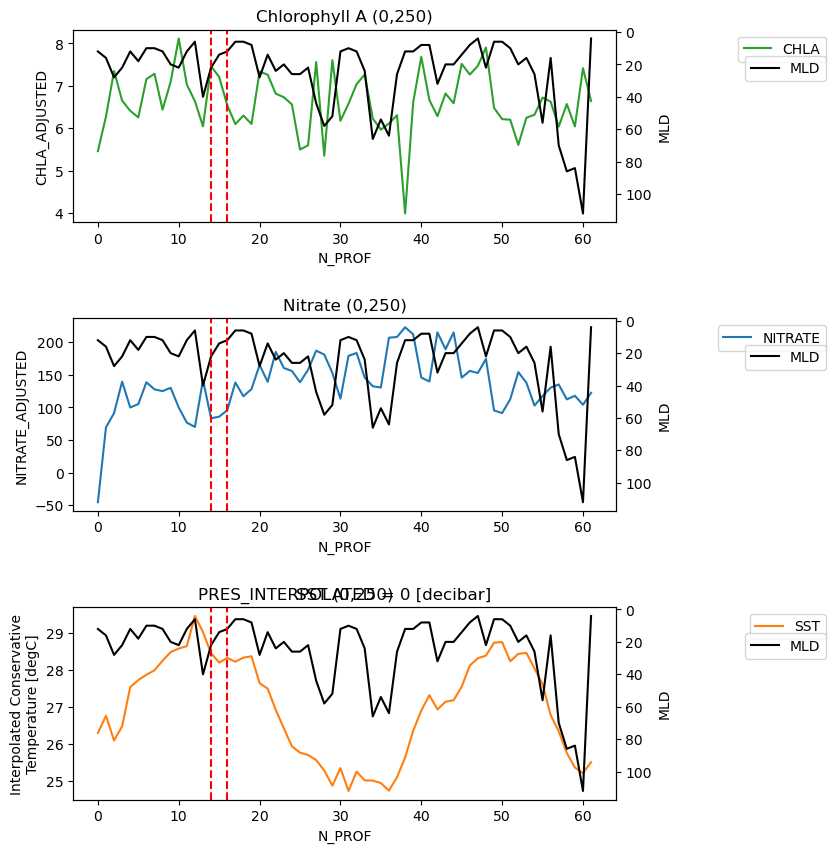

In [310]:
plt.figure(figsize=(7,10))

plt.subplot(311)
float_sum.CHLA_ADJUSTED.plot(label='CHLA',color='tab:green')
plt.legend(bbox_to_anchor=(1.4,1))
plt.twinx()
float_interp.MLD.plot(label='MLD',color='black')
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.4,0.9))
plt.axvline(14,color='r',linestyle='--')
plt.axvline(16,color='r',linestyle='--')
plt.title('Chlorophyll A (0,250)')

plt.subplot(312)
float_sum.NITRATE_ADJUSTED.plot(label='NITRATE',color='tab:blue')
plt.legend(bbox_to_anchor=(1.4,1))
plt.twinx()
float_interp.MLD.plot(label='MLD',color='black')
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.4,0.9))
plt.axvline(14,color='r',linestyle='--')
plt.axvline(16,color='r',linestyle='--')
plt.title('Nitrate (0,250)')

plt.subplot(313)
float_interp.CT.isel(PRES_INTERPOLATED=0).plot(label='SST',color='tab:orange')
#float_interp.isel(PRES_INTERPOLATED=0).plot(label='SST',color='tab:orange')
plt.legend(bbox_to_anchor=(1.4,1))
plt.twinx()
float_interp.MLD.plot(label='MLD',color='black')
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.4,0.9))
plt.axvline(14,color='r',linestyle='--')
plt.axvline(16,color='r',linestyle='--')
plt.title('SST (0,250)')

plt.subplots_adjust(hspace=0.5)

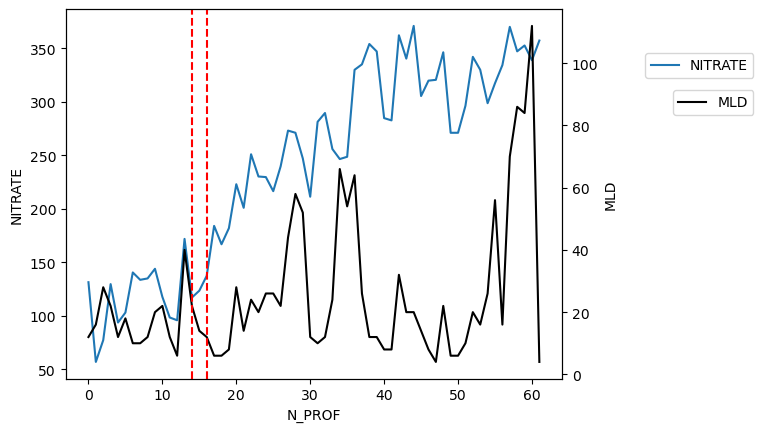

In [311]:
float_sum.NITRATE.plot(label='NITRATE',color='tab:blue')
plt.legend(bbox_to_anchor=(1.4,0.9))
plt.twinx()
float_interp.MLD.plot(label='MLD',color='black')
plt.legend(bbox_to_anchor=(1.4,0.8))
plt.axvline(14,color='r',linestyle='--')
plt.axvline(16,color='r',linestyle='--')

# Grabbing Individual Profiles

In [312]:
float_interp

<xarray.Dataset>
Dimensions:                     (N_PROF: 62, PRES_INTERPOLATED: 500, TIME: 62,
                                 TIME_POSITION: 62)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
  * TIME                        (TIME) datetime64[ns] 2021-05-04T10:58:27.000...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) int64 0 2 4 ... 994 996 998
  * TIME_POSITION               (TIME_POSITION) <U1 'B' 'B' 'B' ... 'A' 'A' 'A'
    MLD                         (N_PROF) int64 12 16 28 22 12 ... 70 86 84 112 4
Data variables: (12/33)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    BBP700_ROLLING              (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 0.0365 .....
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 0.0073 .....
    ...                          ...
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    SA                          (N_PROF, PRES_INTERPOLATED) float64 36.92 ......
    SIG0                        (N_PROF, PRES_INTERPOLATED) float64 24.24 ......
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

In [313]:
str(float_interp.TIME[13].values)

'2021-09-12T08:46:42.000999936'

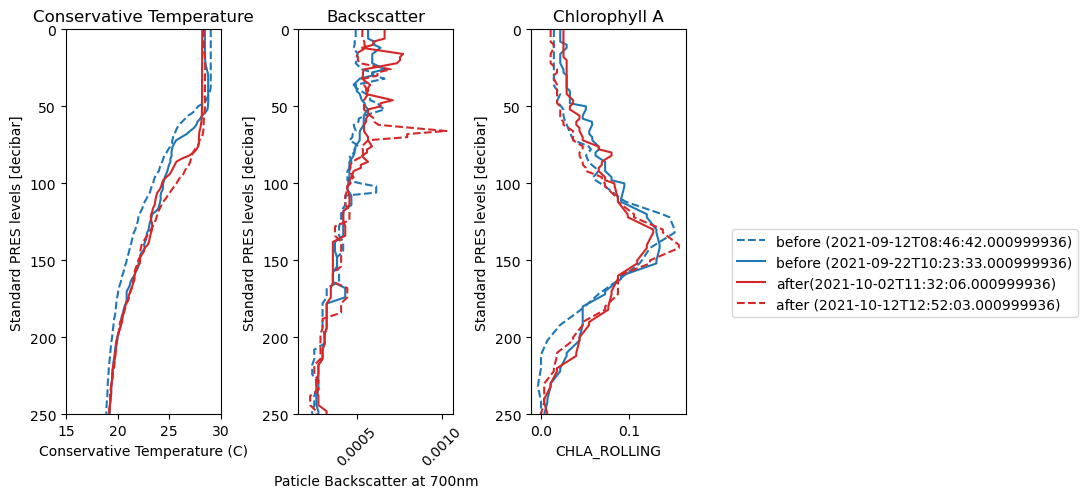

In [377]:
plt.figure(figsize=(8,5))

plt.subplot(131)
float_interp.isel(N_PROF=13).CT.plot(y='PRES_INTERPOLATED',color='tab:blue',linestyle='--',label='before ({})'.format(str(float_interp.TIME[13].values)))
float_interp.isel(N_PROF=14).CT.plot(y='PRES_INTERPOLATED',color='tab:blue',label='before ({})'.format(str(float_interp.TIME[14].values)))
float_interp.isel(N_PROF=15).CT.plot(y='PRES_INTERPOLATED',color='tab:red',label='after ({})'.format(str(float_interp.TIME[15].values)))
float_interp.isel(N_PROF=16).CT.plot(y='PRES_INTERPOLATED',color='tab:red',linestyle='--',label='after ({})'.format(str(float_interp.TIME[16].values)))
plt.gca().invert_yaxis()
plt.ylim(250,0)
plt.xlim(15,30)
plt.xlabel('Conservative Temperature (C)')
#plt.legend()
plt.title('Conservative Temperature')

plt.subplot(132)
float_interp.isel(N_PROF=13).BBP700_ROLLING.plot(y='PRES_INTERPOLATED',color='tab:blue',linestyle='--',label='before ({})'.format(str(float_interp.TIME[13].values)))
float_interp.isel(N_PROF=14).BBP700_ROLLING.plot(y='PRES_INTERPOLATED',color='tab:blue',label='before ({})'.format(str(float_interp.TIME[14].values)))
float_interp.isel(N_PROF=15).BBP700_ROLLING.plot(y='PRES_INTERPOLATED',color='tab:red',label='after ({})'.format(str(float_interp.TIME[15].values)))
float_interp.isel(N_PROF=16).BBP700_ROLLING.plot(y='PRES_INTERPOLATED',color='tab:red',linestyle='--',label='after ({})'.format(str(float_interp.TIME[16].values)))
plt.gca().invert_yaxis()
plt.ylim(250,0)
plt.xlabel('Paticle Backscatter at 700nm')
plt.xticks(rotation=45)
#plt.legend()
plt.title('Backscatter')

plt.subplot(133)
float_interp.isel(N_PROF=13).CHLA_ADJUSTED.plot(y='PRES_INTERPOLATED',color='tab:blue',linestyle='--',label='before ({})'.format(str(float_interp.TIME[13].values)))
float_interp.isel(N_PROF=14).CHLA_ROLLING.plot(y='PRES_INTERPOLATED',color='tab:blue',label='before ({})'.format(str(float_interp.TIME[14].values)))
float_interp.isel(N_PROF=15).CHLA_ROLLING.plot(y='PRES_INTERPOLATED',color='tab:red',label='after({})'.format(str(float_interp.TIME[15].values)))
float_interp.isel(N_PROF=16).CHLA_ROLLING.plot(y='PRES_INTERPOLATED',color='tab:red',linestyle='--',label='after ({})'.format(str(float_interp.TIME[16].values)))
plt.gca().invert_yaxis()
plt.ylim(250,0)
plt.legend(bbox_to_anchor=(1.25,0.5))
plt.title('Chlorophyll A')

plt.subplots_adjust(wspace=0.5)

In [417]:
float_interp.TIME[13:17].values

array(['2021-09-12T08:46:42.000999936', '2021-09-22T10:23:33.000999936',
       '2021-10-02T11:32:06.000999936', '2021-10-12T12:52:03.000999936'],
      dtype='datetime64[ns]')

In [418]:
dates=['Sept 9','Sept 22','Oct 2','Oct 12']

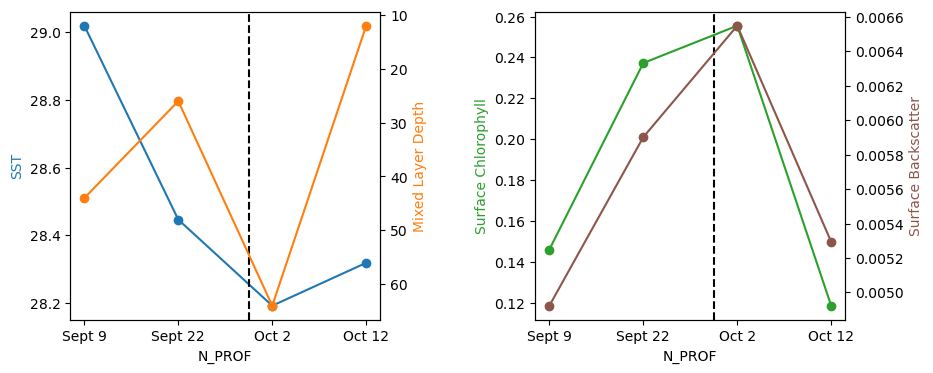

In [457]:
plt.figure(figsize=(10,4))

plt.subplot(121)
float_interp.isel(N_PROF=slice(13,17)).CT.isel(PRES_INTERPOLATED=0).plot(label='Sea Surface Temperature',marker='o')
plt.title('')
plt.xticks(ticks=[13,14,15,16],labels=dates)
plt.axvline(14.75,color='k',linestyle='--')
plt.ylabel('SST',color='tab:blue')
plt.twinx()
float_interp.isel(N_PROF=slice(13,17)).MLD.plot(label='Mixed Layer Depth',color='tab:orange',marker='o')
plt.ylabel('Mixed Layer Depth',color='tab:orange')
plt.gca().invert_yaxis()
plt.title('')

plt.subplot(122)
float_interp.isel(N_PROF=slice(13,17)).CHLA_ROLLING.isel(PRES_INTERPOLATED=slice(0,10)).sum('PRES_INTERPOLATED').plot(label='Surface Chlorophyll',color='tab:green',marker='o')
plt.title('')
plt.xticks(ticks=[13,14,15,16],labels=dates)
plt.axvline(14.75,color='k',linestyle='--')
plt.ylabel('Surface Chlorophyll',color='tab:green')
plt.twinx()
float_interp.isel(N_PROF=slice(13,17)).BBP700_ROLLING.isel(PRES_INTERPOLATED=slice(0,10)).sum('PRES_INTERPOLATED').plot(label='Surface Backscatter',color='tab:brown',marker='o')
plt.ylabel('Surface Backscatter',color='tab:brown')
plt.title('')

plt.subplots_adjust(wspace=0.5)

Text(0.5, 1.0, '')

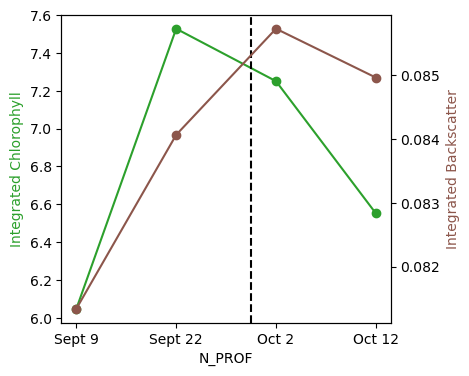

In [462]:
plt.figure(figsize=(4.25,4))
float_interp.isel(N_PROF=slice(13,17)).CHLA_ROLLING.isel(PRES_INTERPOLATED=slice(0,250)).sum('PRES_INTERPOLATED').plot(label='Surface Chlorophyll',color='tab:green',marker='o')
plt.title('')
plt.xticks(ticks=[13,14,15,16],labels=dates)
plt.axvline(14.75,color='k',linestyle='--')
plt.ylabel('Integrated Chlorophyll',color='tab:green')
plt.twinx()
float_interp.isel(N_PROF=slice(13,17)).BBP700_ROLLING.isel(PRES_INTERPOLATED=slice(0,250)).sum('PRES_INTERPOLATED').plot(label='Surface Backscatter',color='tab:brown',marker='o')
plt.ylabel('Integrated Backscatter',color='tab:brown')
plt.title('')